<a href="https://colab.research.google.com/github/ichencyj/AI_ML/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
path = "/content/drive/MyDrive/AI/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


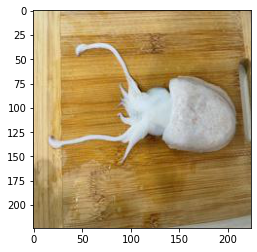

In [ ]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[20]))

In [ ]:
#使用照片來源, 宜君和yandex
import random
import pandas as pd
cuttlefish = glob.glob("train/cuttlefish.*")
random.shuffle(cuttlefish)
octopus = glob.glob("train/octopus.*")
random.shuffle(octopus)
train = pd.DataFrame({
    "path":cuttlefish[:1016] + octopus[:1020],
    "target":[0] * 1016 + [1] * 1020
})
validate = pd.DataFrame({
    "path":cuttlefish[1016:1072] + octopus[1020:1077],
    "target":[0] * 56 + [1] * 57
})
test = pd.DataFrame({
    "path":cuttlefish[1072:1128] + octopus[1077:1134],
    "target":[0] * 56 + [1] * 57
})

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
import numpy as np

In [ ]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
print(img_np)

[[[119.061     138.22101   131.32     ]
  [ 95.061     114.221     118.32     ]
  [ 85.061     105.221     107.32     ]
  ...
  [ 14.060997   32.221      46.32     ]
  [  1.060997   19.221      33.32     ]
  [-11.939003    4.2210007  18.32     ]]

 [[111.061     130.22101   131.32     ]
  [ 90.061     109.221     113.32     ]
  [ 81.061     104.221     105.32     ]
  ...
  [ 18.060997   38.221      51.32     ]
  [  8.060997   26.221      40.32     ]
  [ -3.939003   12.221001   26.32     ]]

 [[ 96.061     118.221     121.32     ]
  [ 80.061     102.221     105.32     ]
  [ 77.061      99.221     102.32     ]
  ...
  [ 22.060997   42.221      55.32     ]
  [ 15.060997   33.221      47.32     ]
  [  4.060997   22.221      36.32     ]]

 ...

 [[ -9.939003   18.221      34.32     ]
  [ -9.939003   18.221      34.32     ]
  [-13.939003   14.221001   30.32     ]
  ...
  [ 52.060997   47.221      40.32     ]
  [ 53.060997   48.221      41.32     ]
  [ 53.060997   48.221      41.32     ]]

 [

In [ ]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [ ]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    # 如果不是None, 那代表是數字(20), 隨機20個idx
    # 如果是None, 那就沒有隨機, 拿全部
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片
    img_pre, img_ori = [], []
    # 走過我的每一個path
    for p in x:
        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [ ]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(113, 224, 224, 3)
(113, 224, 224, 3)


In [ ]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [0.3080054819583893, 0.8999999761581421]
validate: [0.2504112720489502, 0.9026548862457275]
--------------- 0 end ---------------
train: [0.31106072664260864, 0.8999999761581421]
validate: [0.2492087185382843, 0.9026548862457275]
--------------- 1 end ---------------
train: [0.2770208418369293, 0.949999988079071]
validate: [0.2478860318660736, 0.9026548862457275]
--------------- 2 end ---------------
train: [0.25133660435676575, 0.8999999761581421]
validate: [0.24685439467430115, 0.9026548862457275]
--------------- 3 end ---------------
train: [0.2766769230365753, 0.8999999761581421]
validate: [0.24422913789749146, 0.9115044474601746]
--------------- 4 end ---------------
train: [0.33550816774368286, 0.8500000238418579]
validate: [0.2426355928182602, 0.9115044474601746]
--------------- 5 end ---------------
train: [0.22492685914039612, 1.0]
validate: [0.24143539369106293, 0.9115044474601746]
--------------- 6 end ---------------
train: [0.2869384288787842, 0.949999988079071]
val

In [ ]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 0s 113ms/step - loss: 0.2689 - accuracy: 0.9115


[0.26888495683670044, 0.9115044474601746]

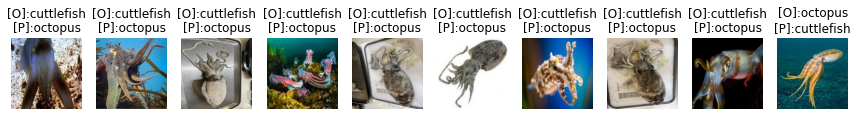

In [ ]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["cuttlefish", "octopus"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

url:https://img3.momoshop.com.tw/expertimg/0009/876/358/mobile/FPF-128-100-1.jpg
cuttlefish 的機率: 0.628
octopus 的機率: 0.372


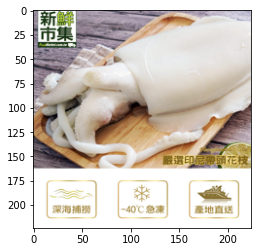

In [ ]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)